**SIGNATE連携**

In [ ]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Download 100%.


In [ ]:
! signate list

  competitionId  title                                                                                         closing     prize            submitters
---------------  --------------------------------------------------------------------------------------------  ----------  -------------  ------------
              1  【Practice】Bank Marketing                                                                    -                                  5106
             24  【Practice】Boxed Lunch Sales Forecasting                                                     -                                  6278
             27  【Practice】Football Attendance Forecasting                                                   -                                  1429
            100  【練習問題】手書き文字認識                                                                    -           Knowledge               157
            102  【練習問題】タイタニックの生存予測                                                            -           Knowled

In [ ]:
! signate files --competition-id=499

  fileId  name                                           title                                                size  updated_at
--------  ---------------------------------------------  ----------------------------------------------  ---------  -------------------
    2219  PBL02_h_exercise4_question.pdf                 PBL02_不良個所自動検出_h.演習④設問                1417656  2021-08-19 15:22:04
    2220  PBL02_i_exercise4_supplementary-documents.pdf  PBL02_不良個所自動検出_i.演習④ガイドコンテンツ     470147  2021-08-19 15:22:07
    2138  train.zip                                      学習用画像データ                                183977509  2021-08-19 15:22:07
    2139  test.zip                                       評価用画像データ                                151304061  2021-08-19 15:22:07
    2140  train_master.tsv                               学習用画像データとラベルIDの対応表                   5221  2021-08-19 15:22:07
    2141  sample_submit.tsv                              応募用サンプルファイル                                100  2021-08-19 15:

In [ ]:
! signate download --competition-id=499

sample_submit.tsv

requirements.txt

train_master.tsv

PBL02_sample_code.ipynb

PBL02_i_exercise4_supplementary-documents.pdf

PBL02_h_exercise4_question.pdf

test.zip

train.zip


Download completed.


In [ ]:
! unzip train.zip
! unzip test.zip

Archive:  train.zip
replace train/bridge/bridge_000.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  test.zip
replace test/000.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
%ls

 adc.json                                            'sample_submit (1).tsv'
 drive/                                               sample_submit.tsv
'PBL02_h_exercise4_question (1).pdf'                  test/
 PBL02_h_exercise4_question.pdf                      'test (1).zip'
'PBL02_i_exercise4_supplementary-documents (1).pdf'   test.zip
 PBL02_i_exercise4_supplementary-documents.pdf        train/
'PBL02_sample_code (1).ipynb'                        'train (1).zip'
 PBL02_sample_code.ipynb                             'train_master (1).tsv'
'requirements (1).txt'                                train_master.tsv
 requirements.txt                                     train.zip
 sample_data/


**コーディングは次のセルから**

# **Import libraries**

In [ ]:
!pip install albumentations==0.4.5

In [ ]:
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import random
import copy
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import (
    Compose, OneOf, Normalize, CenterCrop, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, RandomRotate90, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )

from tqdm import tqdm
from tqdm.notebook import tqdm

# **CFG**

In [ ]:
class CFG:
  DATA_PATH = '/content/'

  TRAIN_PATH = DATA_PATH + 'train/'
  #TRAIN_BRIDGE = TRAIN_PATH + 'bridge/'
  #TRAIN_HORN = TRAIN_PATH + 'horn/'
  #TRAIN_POTATO = TRAIN_PATH + 'potato/'
  #TRAIN_REGULAR = TRAIN_PATH + 'regular/'

  TEST_PATH = DATA_PATH + 'test/'

  TRAIN_TSV = DATA_PATH + 'train_master.tsv'
  SAMPLE_TSV = DATA_PATH + 'sample_submit.tsv'

  IMAGE_SIZE = 32
  BATCH_SIZE = 16
  EPOCH = 10
  CLASS_THRESHOLD = 0.4
  LABELS = ['True','False']
  LR = 5e-4

  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def to_numpy(tensor):
    """Auxiliary function to convert tensors into numpy arrays
    """
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# **Preprocessing dataframe**

In [ ]:
train_df = pd.read_table(CFG.TRAIN_TSV, sep=',')
train_df

,file_name,flag
0,bridge_000.jpeg,1
1,bridge_001.jpeg,1
2,bridge_002.jpeg,1
3,bridge_003.jpeg,1
4,bridge_004.jpeg,1
...,...,...
285,regular_095.jpeg,0
286,regular_096.jpeg,0
287,regular_097.jpeg,0
288,regular_098.jpeg,0


In [ ]:
flag_df = train_df['flag']
flag_df

0      1
1      1
2      1
3      1
4      1
      ..
285    0
286    0
287    0
288    0
289    0
Name: flag, Length: 290, dtype: int64

In [ ]:
#bridgeの個数確認及びbridgeのみデータを一時的なデータフレームとして保存する
train_df[train_df['file_name'].str.startswith('bridge')]
tmp1 = train_df['file_name'][:30]
tmp1

#hornの個数確認及びhornのみデータを一時的なデータフレームとして保存する
train_df[train_df['file_name'].str.startswith('horn')]
tmp2 = train_df['file_name'][30:87]
tmp2

#potatoの個数確認及びpotatoのみデータを一時的なデータフレームとして保存する
train_df[train_df['file_name'].str.startswith('potato')]
tmp3 = train_df['file_name'][87:190]
tmp3

#regularの個数確認及びregularのみデータを一時的なデータフレームとして保存する
train_df[train_df['file_name'].str.startswith('regular')]
tmp4 = train_df['file_name'][190:]
tmp4

190    regular_000.jpeg
191    regular_001.jpeg
192    regular_002.jpeg
193    regular_003.jpeg
194    regular_004.jpeg
             ...       
285    regular_095.jpeg
286    regular_096.jpeg
287    regular_097.jpeg
288    regular_098.jpeg
289    regular_099.jpeg
Name: file_name, Length: 100, dtype: object

In [ ]:
tmp2

30    horn_000.jpeg
31    horn_001.jpeg
32    horn_002.jpeg
33    horn_003.jpeg
34    horn_004.jpeg
35    horn_005.jpeg
36    horn_006.jpeg
37    horn_007.jpeg
38    horn_008.jpeg
39    horn_009.jpeg
40    horn_010.jpeg
41    horn_011.jpeg
42    horn_012.jpeg
43    horn_013.jpeg
44    horn_014.jpeg
45    horn_015.jpeg
46    horn_016.jpeg
47    horn_017.jpeg
48    horn_018.jpeg
49    horn_019.jpeg
50    horn_020.jpeg
51    horn_021.jpeg
52    horn_022.jpeg
53    horn_023.jpeg
54    horn_024.jpeg
55    horn_025.jpeg
56    horn_026.jpeg
57    horn_027.jpeg
58    horn_028.jpeg
59    horn_029.jpeg
60    horn_030.jpeg
61    horn_031.jpeg
62    horn_032.jpeg
63    horn_033.jpeg
64    horn_034.jpeg
65    horn_035.jpeg
66    horn_036.jpeg
67    horn_037.jpeg
68    horn_038.jpeg
69    horn_039.jpeg
70    horn_040.jpeg
71    horn_041.jpeg
72    horn_042.jpeg
73    horn_043.jpeg
74    horn_044.jpeg
75    horn_045.jpeg
76    horn_046.jpeg
77    horn_047.jpeg
78    horn_048.jpeg
79    horn_049.jpeg


In [ ]:
#tmp1-4にはそれぞれの状態に応じたデータフレームが入っている
#それぞれに対応するパス'bridge/','horn/','potato/','regular/'を付け加えて、
#全ての画像を一元的に呼び出せるようにする
bridge_df = 'bridge/'+tmp1
horn_df = 'horn/'+tmp2
potato_df = 'potato/'+tmp3
regular_df = 'regular/'+tmp4

#新しくパスを加えたtrain_dfを作る名前はtrain_df2

train_df2 = pd.concat([bridge_df,horn_df,potato_df,regular_df])
train_df2 = pd.concat([train_df2,flag_df], axis=1)
train_df2

,file_name,flag
0,bridge/bridge_000.jpeg,1
1,bridge/bridge_001.jpeg,1
2,bridge/bridge_002.jpeg,1
3,bridge/bridge_003.jpeg,1
4,bridge/bridge_004.jpeg,1
...,...,...
285,regular/regular_095.jpeg,0
286,regular/regular_096.jpeg,0
287,regular/regular_097.jpeg,0
288,regular/regular_098.jpeg,0


In [ ]:
train_df3 = pd.get_dummies(train_df2, columns=['flag'])
train_df3 = train_df3.rename(columns={'flag_0': 'True'})
train_df3 = train_df3.rename(columns={'flag_1': 'False'})
train_df3

,file_name,True,False
0,bridge/bridge_000.jpeg,0,1
1,bridge/bridge_001.jpeg,0,1
2,bridge/bridge_002.jpeg,0,1
3,bridge/bridge_003.jpeg,0,1
4,bridge/bridge_004.jpeg,0,1
...,...,...,...
285,regular/regular_095.jpeg,1,0
286,regular/regular_096.jpeg,1,0
287,regular/regular_097.jpeg,1,0
288,regular/regular_098.jpeg,1,0


In [ ]:
def visualize_batch(path,image_ids, flags):
  plt.figure(figsize=(16, 12))
  for x, (image_id, flag) in enumerate(zip(image_ids, flags)):
    
    image = cv2.imread(CFG.TRAIN_PATH+train_df2['file_name'][x])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, x + 1)
    plt.title(f"Class: {True}", fontsize=12)
    plt.axis("off")
    plt.imshow(image)
  plt.show()

In [ ]:
sample = train_df2.sample(9)
image_ids = sample['file_name'].values
flags = sample['flag'].values

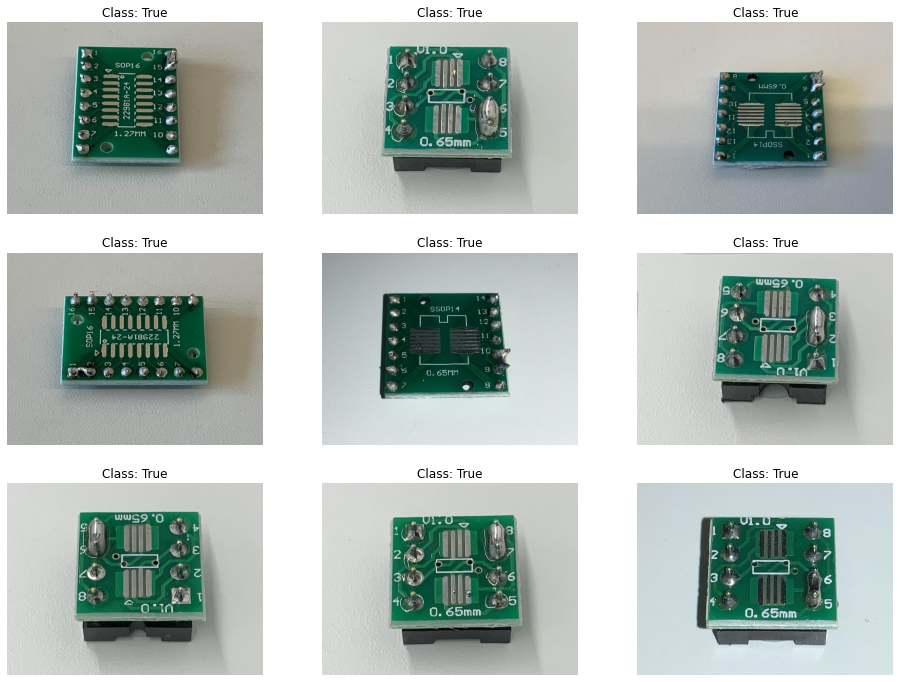

In [ ]:
visualize_batch(CFG.TRAIN_PATH, image_ids, flags)

# **Split dataset**

In [ ]:
from sklearn.model_selection import train_test_split
tr, va =  train_test_split(train_df3, test_size = 0.2)
print(tr.shape, va.shape)

(232, 3) (58, 3)


# **Dataset**

In [ ]:
class TrainDataset(Dataset):
  def __init__(self, train_df3, transform=None):
    self.train_df3 = train_df3
    self.image_names = train_df3['file_name'].values
    self.flags = train_df3[CFG.LABELS].values
    self.transform = transform

  def __len__(self):
    return len(self.train_df3)
  
  def __getitem__(self, idx):
    image_name = self.image_names[idx]
    image_path = CFG.TRAIN_PATH + image_name
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    flag = self.flags[idx] #indexに対応するラベル
    #flag = torch.tensor(self.flags[idx]).float()
    if self.transform:
      augmented = self.transform(image=image)
      image = augmented['image']
      image.shape
    return image, flag

# **Augmentation**

In [ ]:
def get_transforms(*,data):
    
    if data == 'tr':
        return Compose([
            A.Resize(CFG.IMAGE_SIZE, CFG.IMAGE_SIZE),
            A.RandomResizedCrop(CFG.IMAGE_SIZE, CFG.IMAGE_SIZE),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(p=0.5),

            A.Normalize(),
            ToTensorV2(),
        ])
    elif data == 'va':
        return Compose([
            Resize(CFG.IMAGE_SIZE, CFG.IMAGE_SIZE),
            Normalize(),
            ToTensorV2(),
        ])

In [ ]:
# 上で作成したデータセットクラスを呼び出す
train_dataset = TrainDataset(tr, transform = get_transforms(data = 'tr'))
# データセットクラスによって取り出されるデータをbatch数でまとめる
train_loader = DataLoader(train_dataset, CFG.BATCH_SIZE, shuffle = True,drop_last = True, num_workers=2)

valid_dataset = TrainDataset(va, transform = get_transforms(data = 'va'))
valid_loader = DataLoader(valid_dataset, CFG.BATCH_SIZE, shuffle = False, num_workers=2)

In [ ]:
train_dataset[0]

(tensor([[[ 0.0398, -0.3712, -0.7650,  ..., -0.3027, -0.6623, -0.6623],
          [ 0.1426, -0.1828, -0.7308,  ...,  0.2282,  0.0056, -0.3712],
          [-0.1999, -0.5596, -0.9877,  ...,  0.3481,  0.6563,  0.3138],
          ...,
          [-1.0733, -0.3541,  0.3309,  ..., -1.0390, -0.6109,  0.3309],
          [-1.3644, -1.0048, -0.2856,  ..., -0.6794, -0.4397, -0.1999],
          [-1.1932, -1.2445, -0.9020,  ...,  0.1426, -0.3198, -0.5253]],
 
         [[ 0.2227, -0.0574, -0.1625,  ...,  0.0301, -0.1975, -0.0749],
          [ 0.3277,  0.1527, -0.0224,  ...,  0.5028,  0.2927,  0.1176],
          [ 0.1877,  0.1176,  0.0651,  ...,  0.8880,  1.0630,  0.7479],
          ...,
          [-0.4776,  0.1877,  0.7129,  ..., -0.2500, -0.0399,  0.5553],
          [-0.6176, -0.2500,  0.2402,  ..., -0.0749, -0.1099,  0.0476],
          [-0.4951, -0.4951, -0.2850,  ...,  0.4503,  0.0126, -0.1975]],
 
         [[ 0.2173, -0.2358, -0.4275,  ..., -0.0615, -0.3230, -0.1661],
          [ 0.2871,  0.0431,

In [ ]:
DATALOADERS_DICT = {
    'train': train_loader, 
    'valid': valid_loader}

# **Model**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()
model = model.to(CFG.DEVICE)


# **Evaluate function**

In [ ]:
class MetricMonitor:
    def __init__(self):
        self.reset()

    def reset(self):
        self.losses = []
        self.accuracies = []
        self.scores = []
        self.metrics = dict({
            'loss': self.losses,
            'acc': self.accuracies,
            'f1': self.scores
        })

    def update(self, metric_name, value):
        self.metrics[metric_name] += [value]

In [ ]:
def get_metrics(
    y_pred_proba, 
    y_test, 
    threshold=CFG.CLASS_THRESHOLD,
    labels=CFG.LABELS) -> None:
    """
    """
    y_pred = np.where(y_pred_proba > threshold, 1, 0)

    y1 = y_pred.round().astype(np.float)
    y2 = y_test.round().astype(np.float)
    
    
    f1 = f1_score(y1, y2, average='micro')
    acc = accuracy_score(y1, y2, normalize=True)

    return acc, f1

# **Training**

In [ ]:
criterion = nn.BCEWithLogitsLoss().to(CFG.DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LR)

def training_loop(
    dataloader, 
    model, 
    criterion, 
    optimizer, 
    epoch, 
    monitor = MetricMonitor(), 
    train=True
):
    """
    """
    size = len(dataloader.dataset)
    
    loss_val = 0
    accuracy = 0
    f1score = 0
    
    if train:
        model.train()
    else:
        model.eval()
    
    stream = tqdm(dataloader)
    for batch, (X, y) in enumerate(stream, start=1):
        X = X.to(CFG.DEVICE)
        y = y.to(CFG.DEVICE)
        #print(X.shape, y.shape)
        #print(X.dtype, y.dtype)

        
        # compute prediction and loss
        pred_prob = model(X)
        y = y.type_as(pred_prob)
        loss = criterion(pred_prob, y)
    
        if train:
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        
        loss_val += loss.item()
        acc, f1 = get_metrics(to_numpy(pred_prob), to_numpy(y))
        
        accuracy += acc 
        f1score += f1

        phase = 'Train' if train else 'Val'
        stream.set_description(
            f'Epoch {epoch:3d}/{CFG.EPOCH} - {phase} - Loss: {loss_val/batch:.4f}, ' + 
            f'Acc: {accuracy/batch:.4f}, F1: {f1score/batch:.4f}'
        )

    monitor.update('loss', loss_val/batch)
    monitor.update('acc', accuracy/batch)
    monitor.update('f1', f1score/batch)

In [ ]:
train_monitor = MetricMonitor()
test_monitor = MetricMonitor()

In [ ]:
for epoch in range(1, CFG.EPOCH + 1):
    # training loop
    training_loop(
        train_loader, 
        model, 
        criterion, 
        optimizer, 
        epoch, 
        train_monitor,
        train=True
    )
    
    # validation loop
    training_loop(
        valid_loader, 
        model, 
        criterion, 
        optimizer, 
        epoch, 
        test_monitor,
        train=False
    )

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
model_path = 'my_model.pt'
torch.save(model.state_dict(), model_path)

In [ ]:
from matplotlib.ticker import MaxNLocator 

def plot_result(
    train_losses, 
    test_losses, 
    train_accuracies, 
    test_accuracies, 
    train_scores,
    test_scores
) -> None:
    
    epochs = range(1, len(train_losses) + 1)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))
    
    # plot loss values
    ax[0].plot(epochs, train_losses, label='Training loss', marker ='o')
    ax[0].plot(epochs, test_losses, label='Validation loss', marker ='o')
    ax[0].legend(frameon=False, fontsize=14)
    ax[0].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[0].set_title('Loss', fontsize=18)
    ax[0].set_xlabel('Epoch', fontsize=14) 
    ax[0].set_ylabel('Loss', fontsize=14)  
    
    # plot accuracies 
    ax[1].plot(epochs, train_accuracies, label='Training Accuracy', marker ='o')
    ax[1].plot(epochs, test_accuracies, label='Validation accuracy', marker ='o')
    ax[1].legend(frameon=False, fontsize=14)
    ax[1].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[1].set_title('Accuracy', fontsize=18)
    ax[1].set_xlabel('Epoch', fontsize=14) 
    ax[1].set_ylabel('Accuracy', fontsize=14)
    
    ax[2].plot(epochs, train_scores, label='Training F1-Score', marker ='o')
    ax[2].plot(epochs, test_scores, label='Validation F1-Score', marker ='o')
    ax[2].legend(frameon=False, fontsize=14)
    
    ax[2].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax[2].set_title('F1-Score', fontsize=18)
    ax[2].set_xlabel('Epoch', fontsize=14) 
    ax[2].set_ylabel('F1-Score', fontsize=14) 
        
    plt.show()

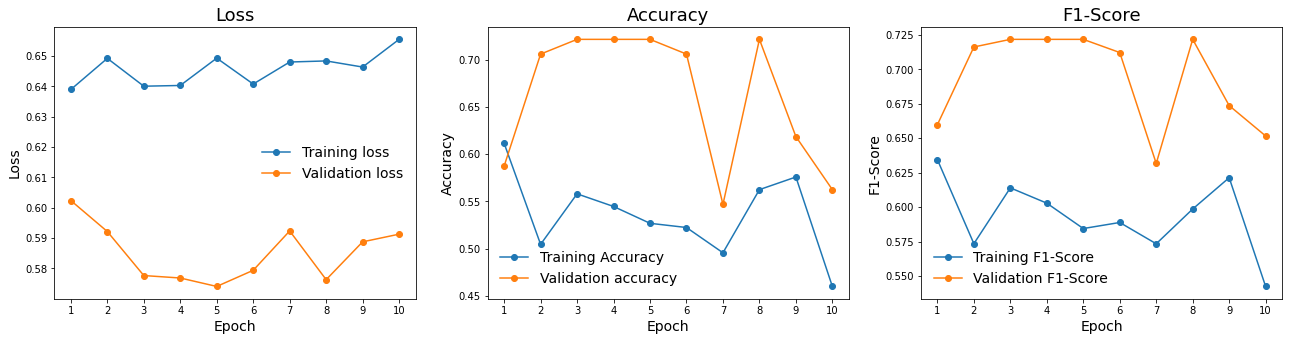

In [ ]:
plot_result(
    train_monitor.losses, 
    test_monitor.losses,
    train_monitor.accuracies, 
    test_monitor.accuracies, 
    train_monitor.scores,
    test_monitor.scores
)    